In this notebook, we will study how homeostasis (cooperation) may be an essential ingredient to this algorithm working on a winner-take-all basis (competition). This extension has been published as Perrinet, Neural Computation (2010) (see  https://laurentperrinet.github.io/publication/perrinet-10-shl ). Compared to the [previous post](https://laurentperrinet.github.io/sciblog/posts/2017-03-29-testing-comps-pcum.html), we optimize the code to be faster.

See also the other posts on [unsupervised learning](https://laurentperrinet.github.io/sciblog/categories/learning.html),

This is joint work with [Victor Boutin](https://laurentperrinet.github.io/authors/victor-boutin).

<!-- TEASER_END -->

Summary: using fast Pcum functions works with approx 80 times speed-up, and one needs to learn the non-linear functions

In [60]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
np.set_printoptions(formatter = dict( float = lambda x: "%.3g" % x ), precision=3, suppress=True, threshold=np.inf)
from shl_scripts.shl_experiments import SHL
import time
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
DEBUG = True
DEBUG = False
if not DEBUG:
    matname = '2017-05-31_Testing_COMPs'
    DEBUG_DOWNSCALE = 1
else:
    matname = '2017-05-31_Testing_COMPs-DEBUG'
    DEBUG_DOWNSCALE = 10

seed = 42
nb_quant = 512
C = 5.
do_sym = False

from shl_scripts.shl_experiments import SHL
shl = SHL(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, 
          datapath='/tmp/database', seed=seed, 
           eta=0.05, verbose=2, record_each=50, n_iter=1000, eta_homeo=0., alpha_homeo=1., 
          do_sym=do_sym, nb_quant=nb_quant, C=C)
data = shl.get_data(matname=matname)

loading the data called : data_cache/2017-05-31_Testing_COMPs_data


In [62]:
test_size = data.shape[0]//2
data_training = data[:test_size, :]
data_test = data[test_size:,:]   
#DEBUG
test_size = data.shape[0]//20
data_training = data[:(data.shape[0]-test_size),:].copy()
data_test = data[:test_size, :].copy()

In [63]:
dico_partial_learning = shl.learn_dico(data=data_training, matname=matname)

loading the dico called : data_cache/2017-05-31_Testing_COMPs_dico.pkl


We start off by using a short learning with no homeostasis such that we end up with a unbalanced dictionary:

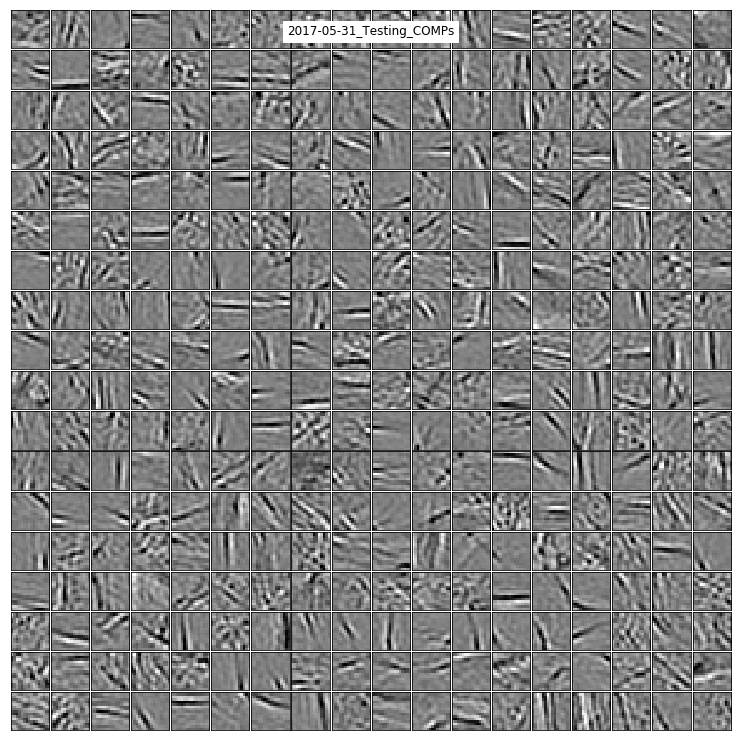

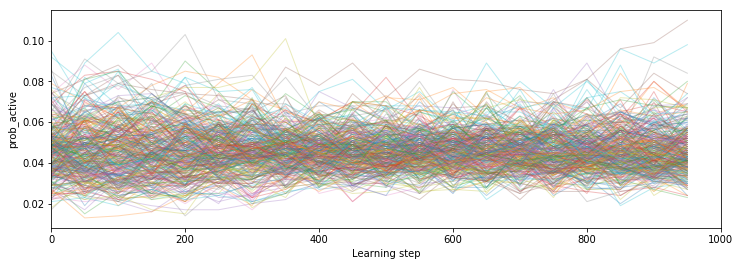

In [64]:
fig, ax = shl.show_dico(dico_partial_learning, data=data, title=matname)
fig.show()
fig, ax = shl.time_plot(dico_partial_learning, variable='prob_active');
fig.show()

## MP classique

loading the code called : data_cache/2017-05-31_Testing_COMPs_coding.npy


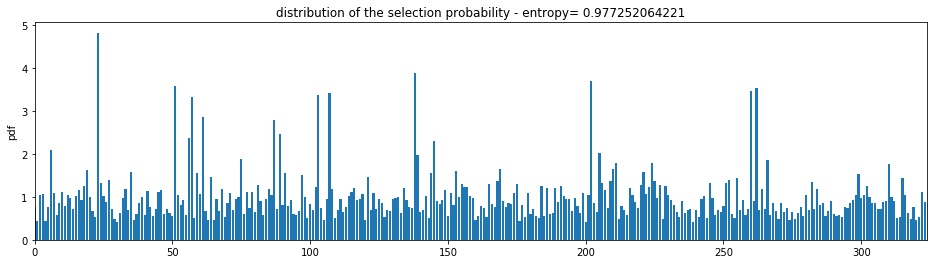

In [65]:
n_samples, n_pixels = data_test.shape
n_dictionary, n_pixels = dico_partial_learning.dictionary.shape
norm_each_filter = np.sqrt(np.sum(dico_partial_learning.dictionary**2, axis=1))
dico_partial_learning.dictionary /= norm_each_filter[:,np.newaxis]

sparse_code_mp = shl.code(data_test, dico_partial_learning, matname=matname)


def plot_proba_histogram(coding, verbose=False):
    n_dictionary=coding.shape[1]

    p = np.count_nonzero(coding, axis=0)/coding.shape[1]
    p /= p.sum()

    rel_ent = np.sum( -p * np.log(p)) / np.log(n_dictionary)
    if verbose: print('Entropy / Entropy_max=', rel_ent )

    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(111)
    ax.bar(np.arange(n_dictionary), p*n_dictionary)
    ax.set_title('distribution of the selection probability - entropy= ' + str(rel_ent)  )
    ax.set_ylabel('pdf')
    ax.axis('tight')
    ax.set_xlim(0, n_dictionary)
    return fig, ax

fig, ax = plot_proba_histogram(sparse_code_mp)

## COMP : learning modulations

computing histograms is rather fast:

In [66]:
np.linspace(0., 1, nb_quant, endpoint=True)

array([0, 0.00196, 0.00391, 0.00587, 0.00783, 0.00978, 0.0117, 0.0137,
       0.0157, 0.0176, 0.0196, 0.0215, 0.0235, 0.0254, 0.0274, 0.0294,
       0.0313, 0.0333, 0.0352, 0.0372, 0.0391, 0.0411, 0.0431, 0.045,
       0.047, 0.0489, 0.0509, 0.0528, 0.0548, 0.0568, 0.0587, 0.0607,
       0.0626, 0.0646, 0.0665, 0.0685, 0.0705, 0.0724, 0.0744, 0.0763,
       0.0783, 0.0802, 0.0822, 0.0841, 0.0861, 0.0881, 0.09, 0.092, 0.0939,
       0.0959, 0.0978, 0.0998, 0.102, 0.104, 0.106, 0.108, 0.11, 0.112,
       0.114, 0.115, 0.117, 0.119, 0.121, 0.123, 0.125, 0.127, 0.129,
       0.131, 0.133, 0.135, 0.137, 0.139, 0.141, 0.143, 0.145, 0.147,
       0.149, 0.151, 0.153, 0.155, 0.157, 0.159, 0.16, 0.162, 0.164, 0.166,
       0.168, 0.17, 0.172, 0.174, 0.176, 0.178, 0.18, 0.182, 0.184, 0.186,
       0.188, 0.19, 0.192, 0.194, 0.196, 0.198, 0.2, 0.202, 0.204, 0.205,
       0.207, 0.209, 0.211, 0.213, 0.215, 0.217, 0.219, 0.221, 0.223,
       0.225, 0.227, 0.229, 0.231, 0.233, 0.235, 0.237, 0.239, 0

In [67]:
def get_P_cum(code, C, nb_quant=100, do_sym=True, verbose=False):
    from shl_scripts.shl_encode import rescaling
    p_c = rescaling(code=code, C=C, do_sym=do_sym, verbose=verbose)

    n_samples, nb_filter = code.shape
    code_bins = np.linspace(0., 1., nb_quant, endpoint=True)
    P_cum = np.zeros((nb_filter, nb_quant))
    for i in range(nb_filter):
        p, bins = np.histogram(p_c[:, i], bins=code_bins, density=True)
        p /= p.sum()
        P_cum[i, :] = np.hstack((0, np.cumsum(p)))
    return P_cum

In [68]:
%%time
P_cum = get_P_cum(sparse_code_mp, C=C, nb_quant=nb_quant)

CPU times: user 124 ms, sys: 15.3 ms, total: 139 ms
Wall time: 155 ms


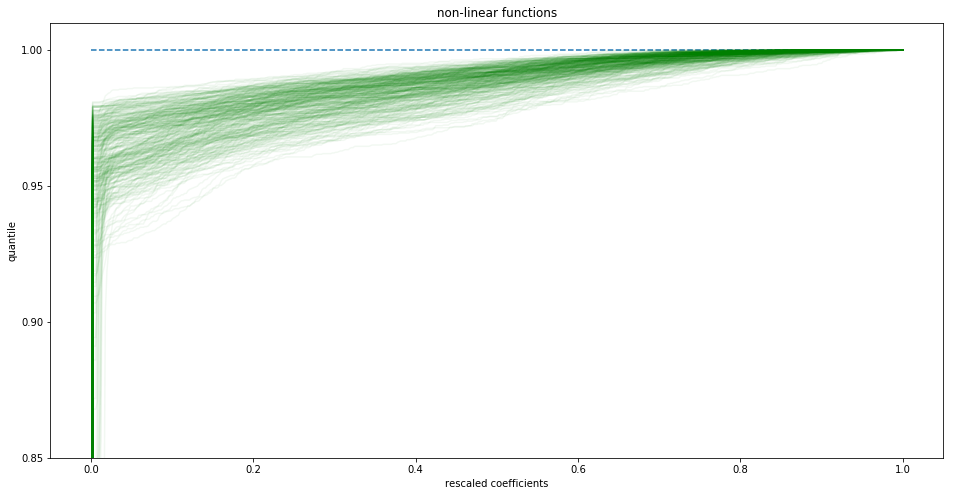

In [69]:
P_cum = get_P_cum(sparse_code_mp, nb_quant=shl.nb_quant, C=C, do_sym=do_sym)
from shl_scripts.shl_tools import plot_P_cum
fig, ax = plot_P_cum(P_cum, verbose=False, alpha=.05)
ax.set_ylim(0.85, 1.01);

## COMP : optimizing the quantile function

### optimizing the quantile function

The ``quantile`` function is used at each iteration of comp and should be optimized:

In [70]:
from shl_scripts.shl_encode import rescaling
corr = (data_test @ dico_partial_learning.dictionary.T)[0, :]
print('correlation=', corr)
print('transformed correlation=', rescaling(corr, C=C, do_sym=do_sym))

correlation= [-0.578 2.52 0.51 -0.0995 -0.48 -0.397 -1.18 1.01 0.368 -0.0685 -0.638 0.73
 0.662 -0.177 -0.735 -0.16 -0.313 -0.408 0.194 -0.0507 0.0542 -0.224 0.245
 0.213 0.606 0.375 0.375 0.24 0.31 0.798 0.0375 -0.36 -1.16 0.327 -0.447
 -0.221 -0.174 -0.503 0.403 -0.02 -0.318 -0.000521 -1.63 0.932 -1.4 -0.0734
 0.511 -1.93 -0.273 0.0229 -0.257 -0.173 0.41 -0.287 -0.00687 -0.0753 0.386
 -0.586 -0.351 -0.225 0.466 1.95 -0.144 -0.768 -0.159 0.761 -0.0439 -1.94
 0.00655 0.322 0.0772 0.0734 -0.395 -0.445 -0.114 0.00327 0.467 -0.417 0.49
 0.62 -0.183 0.696 0.302 -0.354 0.146 -0.225 -0.873 -0.321 0.398 0.514
 -0.705 0.174 -0.143 0.417 -1.59 0.0991 -0.407 -0.294 0.612 0.172 -0.761
 0.389 0.235 0.354 1.12 -0.945 -0.643 0.656 0.22 -0.478 -0.929 -0.876 2.81
 0.309 -0.0675 1.09 -0.0483 0.247 0.265 -0.199 0.416 0.213 -0.102 0.5 0.72
 0.876 -0.0915 -0.947 0.465 0.544 -0.488 0.323 0.09 1.09 0.294 0.597 0.053
 0.583 0.302 -0.328 -0.711 -0.283 0.737 0.35 -0.231 0.306 0.0878 -0.0276
 -1.05 -0.371 -0.47

In [71]:
%%time
code_bins = np.linspace(0., 1, shl.nb_quant, endpoint=True)
def quantile(P_cum, c):
    q_res = np.zeros_like(c)
    for i in range(P_cum.shape[0]):
        q_res[i] = np.interp(c[i], code_bins, P_cum[i, :])
    return q_res

q_vanilla = quantile(P_cum, rescaling(corr, C=C, do_sym=do_sym))

CPU times: user 3.21 ms, sys: 1.39 ms, total: 4.6 ms
Wall time: 3.67 ms


In [72]:
print('quantiles=', q_vanilla)

quantiles= [0 0.991 0.961 0 0 0 0 0.977 0.98 0 0 0.978 0.972 0 0 0 0 0 0.969 0 0.954 0
 0.977 0.945 0.972 0.961 0.965 0.952 0.975 0.983 0.981 0 0 0.951 0 0 0 0
 0.972 0 0 0 0 0.979 0 0 0.978 0 0 0.972 0 0 0.96 0 0 0 0.96 0 0 0 0.957
 0.986 0 0 0 0.981 0 0 0.632 0.979 0.963 0.951 0 0 0 0.305 0.975 0 0.977
 0.973 0 0.962 0.963 0 0.96 0 0 0 0.968 0.974 0 0.932 0 0.96 0 0.973 0 0
 0.962 0.977 0 0.971 0.944 0.957 0.983 0 0 0.978 0.947 0 0 0 0.987 0.971 0
 0.979 0 0.963 0.961 0 0.982 0.958 0 0.962 0.975 0.972 0 0 0.976 0.976 0
 0.957 0.955 0.984 0.96 0.971 0.965 0.977 0.967 0 0 0 0.977 0.98 0 0.958
 0.959 0 0 0 0 0 0.978 0 0.958 0 0 0.963 0 0 0.982 0 0 0.978 0 0 0.962 0 0
 0.938 0.972 0.971 0 0.962 0.95 0 0.988 0 0 0 0.979 0.971 0 0 0.977 0.979
 0.953 0.979 0.971 0.946 0 0 0.965 0 0.986 0 0 0.968 0.978 0.962 0 0 0
 0.896 0 0 0.95 0.958 0 0 0 0.957 0 0 0.979 0 0.95 0.956 0 0.981 0 0.986 0
 0 0.956 0 0.979 0 0 0 0 0.958 0 0 0 0.978 0.985 0.981 0.971 0 0.98 0.983
 0.957 0.956 0.982 0 0 0.976 0.

In [73]:
%%timeit
quantile(P_cum, rescaling(corr, C=C, do_sym=do_sym))

100 loops, best of 3: 2.9 ms per loop



### optimizing the quantile function: fast interpolation

Let's try a quick interpolation in the linearly spaced bins either with or without linear interpolation:

In [74]:
def quantile(P_cum, p_c, do_linear=True):
    q_res = np.zeros_like(p_c)
    for i in range(P_cum.shape[0]):
        if not do_linear:
            q_res[i] = P_cum[i, int(p_c[i]*shl.nb_quant)]
        else:
            if p_c[i]>0:
                p = p_c[i]*shl.nb_quant - int(p_c[i]*shl.nb_quant)
                floor = P_cum[i, int(p_c[i]*shl.nb_quant)] 
                ceil = P_cum[i, int(p_c[i]*shl.nb_quant)+1 -(p_c[i]==1) ]
                q_res[i] = (1-p) * floor + p * ceil
    return q_res

In [75]:
%%time
q_ind = quantile(P_cum, rescaling(corr, C=C, do_sym=do_sym), do_linear=False)

CPU times: user 737 µs, sys: 455 µs, total: 1.19 ms
Wall time: 982 µs


In [76]:
print('relative error=', np.sum((q_ind-q_vanilla)**2) / np.sum(q_vanilla**2))

relative error= 0.00922151212194


In [77]:
%%time
q_ind = quantile(P_cum, rescaling(corr, C=C, do_sym=do_sym), do_linear=True)

CPU times: user 1.96 ms, sys: 20 µs, total: 1.98 ms
Wall time: 1.98 ms


In [78]:
print('relative error=', np.sum((q_ind-q_vanilla)**2)/np.sum((q_vanilla)**2))

relative error= 3.60792273345e-08


In [79]:
%%timeit
quantile(P_cum, rescaling(corr, C=C, do_sym=do_sym))

100 loops, best of 3: 2.7 ms per loop


In [80]:
print('quantiles=', q_ind)

quantiles= [0 0.991 0.961 0 0 0 0 0.977 0.98 0 0 0.978 0.972 0 0 0 0 0 0.969 0 0.954 0
 0.977 0.945 0.972 0.961 0.965 0.952 0.975 0.983 0.981 0 0 0.951 0 0 0 0
 0.972 0 0 0 0 0.979 0 0 0.978 0 0 0.972 0 0 0.96 0 0 0 0.96 0 0 0 0.957
 0.986 0 0 0 0.981 0 0 0.633 0.979 0.963 0.951 0 0 0 0.305 0.975 0 0.977
 0.973 0 0.962 0.963 0 0.96 0 0 0 0.968 0.974 0 0.932 0 0.96 0 0.973 0 0
 0.962 0.977 0 0.971 0.944 0.957 0.983 0 0 0.978 0.947 0 0 0 0.987 0.971 0
 0.979 0 0.963 0.961 0 0.982 0.958 0 0.962 0.975 0.972 0 0 0.976 0.976 0
 0.957 0.955 0.984 0.96 0.971 0.965 0.977 0.967 0 0 0 0.977 0.98 0 0.958
 0.959 0 0 0 0 0 0.978 0 0.958 0 0 0.963 0 0 0.982 0 0 0.978 0 0 0.962 0 0
 0.938 0.972 0.971 0 0.962 0.95 0 0.988 0 0 0 0.979 0.971 0 0 0.977 0.979
 0.953 0.979 0.971 0.946 0 0 0.965 0 0.986 0 0 0.968 0.978 0.962 0 0 0
 0.898 0 0 0.95 0.958 0 0 0 0.957 0 0 0.979 0 0.95 0.956 0 0.981 0 0.986 0
 0 0.956 0 0.979 0 0 0 0 0.958 0 0 0 0.978 0.985 0.981 0.971 0 0.98 0.983
 0.957 0.956 0.982 0 0 0.976 0.

In [81]:
print('quantiles=', (q_ind-q_vanilla).max())

quantiles= 0.00175350566799


This small difference comes from the fact that we switched from a linear to a "nearest neighbor" interpolation.
This code is approximately 8 times faster...

### optimizing the quantile function: vectorization

Let's proceed to vectorize this function further:

In [82]:
(rescaling(corr, C=C, do_sym=do_sym)*shl.nb_quant).astype(np.int)

array([  0, 202,  49,   0,   0,   0,   0,  93,  36,   0,   0,  69,  63,
         0,   0,   0,   0,   0,  19,   0,   5,   0,  24,  21,  58,  36,
        37,  24,  30,  75,   3,   0,   0,  32,   0,   0,   0,   0,  39,
         0,   0,   0,   0,  87,   0,   0,  49,   0,   0,   2,   0,   0,
        40,   0,   0,   0,  38,   0,   0,   0,  45, 165,   0,   0,   0,
        72,   0,   0,   0,  31,   7,   7,   0,   0,   0,   0,  45,   0,
        47,  59,   0,  66,  29,   0,  14,   0,   0,   0,  39,  50,   0,
        17,   0,  41,   0,  10,   0,   0,  59,  17,   0,  38,  23,  34,
       102,   0,   0,  62,  22,   0,   0,   0, 220,  30,   0, 100,   0,
        24,  26,   0,  40,  21,   0,  48,  68,  82,   0,   0,  45,  52,
         0,  32,   9, 100,  29,  57,   5,  56,  29,   0,   0,   0,  70,
        34,   0,  30,   8,   0,   0,   0,   0,   0,  91,   0,  22,   0,
         0,  36,   0,   0,  31,   0,   0,  72,   0,   0,   2,   0,   0,
        51,  74,  41,   0,   6,   3,   0, 165,   0,   0,   0,  6

See https://laurentperrinet.github.io/sciblog/posts/2016-11-17-finding-extremal-values-in-a-nd-array.html

In [83]:
print(P_cum[0, :], P_cum.ravel()[:shl.nb_quant])

[0 0.964 0.964 0.964 0.964 0.964 0.965 0.965 0.965 0.965 0.966 0.966 0.966
 0.966 0.966 0.967 0.967 0.968 0.968 0.968 0.968 0.969 0.969 0.969 0.969
 0.969 0.969 0.969 0.97 0.97 0.97 0.97 0.97 0.97 0.97 0.97 0.97 0.971 0.971
 0.971 0.971 0.971 0.972 0.972 0.972 0.972 0.972 0.972 0.973 0.973 0.973
 0.973 0.974 0.974 0.974 0.974 0.975 0.975 0.975 0.976 0.976 0.976 0.976
 0.976 0.976 0.977 0.977 0.977 0.977 0.978 0.978 0.978 0.979 0.979 0.979
 0.979 0.979 0.98 0.98 0.98 0.98 0.98 0.98 0.981 0.981 0.981 0.981 0.981
 0.982 0.982 0.982 0.982 0.982 0.982 0.982 0.982 0.982 0.983 0.983 0.983
 0.983 0.983 0.984 0.984 0.984 0.984 0.984 0.984 0.984 0.984 0.984 0.984
 0.984 0.984 0.984 0.984 0.984 0.985 0.985 0.985 0.985 0.985 0.985 0.985
 0.985 0.985 0.985 0.985 0.985 0.985 0.985 0.985 0.985 0.985 0.985 0.985
 0.985 0.985 0.985 0.985 0.985 0.985 0.986 0.986 0.986 0.986 0.986 0.986
 0.986 0.986 0.986 0.986 0.986 0.986 0.986 0.986 0.987 0.987 0.987 0.987
 0.987 0.987 0.987 0.987 0.988 0.988 0.988 0.9

adding the index to scan the raveled ``P_cum`` matrix, denoting it as a "stick" marking the index of the index of each line of ``P_cum``

In [84]:
stick = np.arange(P_cum.shape[0])*shl.nb_quant
stick

array([     0,    512,   1024,   1536,   2048,   2560,   3072,   3584,
         4096,   4608,   5120,   5632,   6144,   6656,   7168,   7680,
         8192,   8704,   9216,   9728,  10240,  10752,  11264,  11776,
        12288,  12800,  13312,  13824,  14336,  14848,  15360,  15872,
        16384,  16896,  17408,  17920,  18432,  18944,  19456,  19968,
        20480,  20992,  21504,  22016,  22528,  23040,  23552,  24064,
        24576,  25088,  25600,  26112,  26624,  27136,  27648,  28160,
        28672,  29184,  29696,  30208,  30720,  31232,  31744,  32256,
        32768,  33280,  33792,  34304,  34816,  35328,  35840,  36352,
        36864,  37376,  37888,  38400,  38912,  39424,  39936,  40448,
        40960,  41472,  41984,  42496,  43008,  43520,  44032,  44544,
        45056,  45568,  46080,  46592,  47104,  47616,  48128,  48640,
        49152,  49664,  50176,  50688,  51200,  51712,  52224,  52736,
        53248,  53760,  54272,  54784,  55296,  55808,  56320,  56832,
      

such that the indices in the raveled matrix is:

In [85]:
(rescaling(corr, C=C, do_sym=do_sym)*shl.nb_quant).astype(np.int) + stick

array([     0,    714,   1073,   1536,   2048,   2560,   3072,   3677,
         4132,   4608,   5120,   5701,   6207,   6656,   7168,   7680,
         8192,   8704,   9235,   9728,  10245,  10752,  11288,  11797,
        12346,  12836,  13349,  13848,  14366,  14923,  15363,  15872,
        16384,  16928,  17408,  17920,  18432,  18944,  19495,  19968,
        20480,  20992,  21504,  22103,  22528,  23040,  23601,  24064,
        24576,  25090,  25600,  26112,  26664,  27136,  27648,  28160,
        28710,  29184,  29696,  30208,  30765,  31397,  31744,  32256,
        32768,  33352,  33792,  34304,  34816,  35359,  35847,  36359,
        36864,  37376,  37888,  38400,  38957,  39424,  39983,  40507,
        40960,  41538,  42013,  42496,  43022,  43520,  44032,  44544,
        45095,  45618,  46080,  46609,  47104,  47657,  48128,  48650,
        49152,  49664,  50235,  50705,  51200,  51750,  52247,  52770,
        53350,  53760,  54272,  54846,  55318,  55808,  56320,  56832,
      

We should be careful to the border cases such as $p_c=1$ :

In [86]:
p_c = np.ones_like(corr)
print('Index before correction', (p_c*shl.nb_quant ).astype(np.int) + stick)
print('Index after correction', (p_c*shl.nb_quant - (p_c==1)).astype(np.int) + stick)

Index before correction [   512   1024   1536   2048   2560   3072   3584   4096   4608   5120
   5632   6144   6656   7168   7680   8192   8704   9216   9728  10240
  10752  11264  11776  12288  12800  13312  13824  14336  14848  15360
  15872  16384  16896  17408  17920  18432  18944  19456  19968  20480
  20992  21504  22016  22528  23040  23552  24064  24576  25088  25600
  26112  26624  27136  27648  28160  28672  29184  29696  30208  30720
  31232  31744  32256  32768  33280  33792  34304  34816  35328  35840
  36352  36864  37376  37888  38400  38912  39424  39936  40448  40960
  41472  41984  42496  43008  43520  44032  44544  45056  45568  46080
  46592  47104  47616  48128  48640  49152  49664  50176  50688  51200
  51712  52224  52736  53248  53760  54272  54784  55296  55808  56320
  56832  57344  57856  58368  58880  59392  59904  60416  60928  61440
  61952  62464  62976  63488  64000  64512  65024  65536  66048  66560
  67072  67584  68096  68608  69120  69632  70144  70

In [87]:
p_c = rescaling(corr, C=C, do_sym=do_sym)

In [88]:
%%time
def quantile(P_cum, p_c):
    return P_cum.ravel()[(p_c*shl.nb_quant - (p_c==1)).astype(np.int) + np.arange(P_cum.shape[0])*shl.nb_quant]

q_vec = quantile(P_cum, p_c)

CPU times: user 68 µs, sys: 8 µs, total: 76 µs
Wall time: 82 µs


In [89]:
%%timeit
quantile(P_cum, p_c)

10000 loops, best of 3: 21.8 µs per loop


getting even a bit further using a precomputed "stick" for the different indices yields:

In [90]:
stick = np.arange(P_cum.shape[0])*shl.nb_quant

In [91]:
print("shape of stick is ", stick.shape)
print("shape of vector ", (p_c*P_cum.shape[1]).astype(np.int).shape)

shape of stick is  (324,)
shape of vector  (324,)


In [92]:
%%time
def quantile(P_cum, p_c, stick):
    return P_cum.ravel()[(p_c*shl.nb_quant - (p_c==1)).astype(np.int) + stick]

q_vec = quantile(P_cum, p_c, stick)

CPU times: user 53 µs, sys: 1e+03 ns, total: 54 µs
Wall time: 57.9 µs


In [93]:
%%timeit
quantile(P_cum, p_c, stick)

The slowest run took 10.63 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 22.4 µs per loop


In [94]:
print('relative difference=', (q_vec-q_vanilla).std()/(q_vanilla).std())

relative difference= 0.131825531641


In [95]:
print('relative difference=', (q_vec-q_ind).std()/(q_ind).std())

relative difference= 0.132079141511


Finally, vectorization allows to go $10\times 8$ faster.

Note: We check that values are still ok on the borders :

In [96]:
#from shl_scripts.shl_encode import quantile, rescaling

stick = np.arange(shl.n_dictionary)*shl.nb_quant
print('Value for ones = ', quantile(P_cum, rescaling(np.inf*np.ones(shl.n_dictionary), C=C), stick))
print('Value for zeros = ', quantile(P_cum, rescaling(np.zeros(shl.n_dictionary), C=C), stick))

Value for ones =  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Value for zeros =  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 


### optimizing the quantile function: vectorization with linear interpolation

To improve the precision (and thus decrease the number of quantification steps) we can do a linear interpolation:


In [110]:
%%time
def quantile(P_cum, p_c, stick):
    indices = (p_c*shl.nb_quant).astype(np.int) # (floor) index of each p_c in the respective line of P_cum
    p = p_c*shl.nb_quant - indices # ratio between floor and ceil
    floor = P_cum.ravel()[indices - (p_c==1) + stick] # floor, accounting for extremes, and moved on the raveled P_cum matrix
    ceil = P_cum.ravel()[indices + 1 - (p_c==0) - (p_c==1) - (indices>=P_cum.shape[1]-1) + stick] # ceiling,  accounting for both extremes, and moved similarly
    return (1-p) * floor + p * ceil

q_vec = quantile(P_cum, p_c, stick)

CPU times: user 128 µs, sys: 39 µs, total: 167 µs
Wall time: 142 µs


In [111]:
%%timeit
quantile(P_cum, p_c, stick)

10000 loops, best of 3: 64.1 µs per loop


In [112]:
print('relative error=', np.sum((q_vec-q_vanilla)**2)/np.sum((q_vanilla)**2))

relative error= 1.13451394782


In [113]:
print(np.prod(P_cum.shape))

165888


Note that when interpolating, we should be careful to the border cases such as $p_c=1$ or more generally the cases where the index is the last from the line :

In [118]:
p_c = np.ones_like(corr)
indices = (p_c*shl.nb_quant ).astype(np.int)
print('Index before correction', indices + stick)
print('Index after correction', indices + 1 - (p_c==0) - (p_c==1) - (indices>=stick+P_cum.shape[1]-1) + stick)

Index before correction [   512   1024   1536   2048   2560   3072   3584   4096   4608   5120
   5632   6144   6656   7168   7680   8192   8704   9216   9728  10240
  10752  11264  11776  12288  12800  13312  13824  14336  14848  15360
  15872  16384  16896  17408  17920  18432  18944  19456  19968  20480
  20992  21504  22016  22528  23040  23552  24064  24576  25088  25600
  26112  26624  27136  27648  28160  28672  29184  29696  30208  30720
  31232  31744  32256  32768  33280  33792  34304  34816  35328  35840
  36352  36864  37376  37888  38400  38912  39424  39936  40448  40960
  41472  41984  42496  43008  43520  44032  44544  45056  45568  46080
  46592  47104  47616  48128  48640  49152  49664  50176  50688  51200
  51712  52224  52736  53248  53760  54272  54784  55296  55808  56320
  56832  57344  57856  58368  58880  59392  59904  60416  60928  61440
  61952  62464  62976  63488  64000  64512  65024  65536  66048  66560
  67072  67584  68096  68608  69120  69632  70144  70

In [115]:
corr_test = np.zeros_like(corr)
p_c = rescaling(corr_test, C=C, do_sym=do_sym)
indices = (p_c*shl.nb_quant ).astype(np.int)
print('Index before correction', indices + stick)
print('Index after correction', indices + 1 - (p_c==0) - (p_c==1) - (indices>=stick+P_cum.shape[1]-1) + stick)

Index before correction [     0    512   1024   1536   2048   2560   3072   3584   4096   4608
   5120   5632   6144   6656   7168   7680   8192   8704   9216   9728
  10240  10752  11264  11776  12288  12800  13312  13824  14336  14848
  15360  15872  16384  16896  17408  17920  18432  18944  19456  19968
  20480  20992  21504  22016  22528  23040  23552  24064  24576  25088
  25600  26112  26624  27136  27648  28160  28672  29184  29696  30208
  30720  31232  31744  32256  32768  33280  33792  34304  34816  35328
  35840  36352  36864  37376  37888  38400  38912  39424  39936  40448
  40960  41472  41984  42496  43008  43520  44032  44544  45056  45568
  46080  46592  47104  47616  48128  48640  49152  49664  50176  50688
  51200  51712  52224  52736  53248  53760  54272  54784  55296  55808
  56320  56832  57344  57856  58368  58880  59392  59904  60416  60928
  61440  61952  62464  62976  63488  64000  64512  65024  65536  66048
  66560  67072  67584  68096  68608  69120  69632  70

In [119]:
p_c = 0.9999*np.ones_like(corr)
indices = (p_c*shl.nb_quant ).astype(np.int)
print('Index before correction', indices + stick)
print('Index after correction', indices + 1 - (p_c==0) - (p_c==1) - (indices>=stick+P_cum.shape[1]-1) + stick)

Index before correction [   511   1023   1535   2047   2559   3071   3583   4095   4607   5119
   5631   6143   6655   7167   7679   8191   8703   9215   9727  10239
  10751  11263  11775  12287  12799  13311  13823  14335  14847  15359
  15871  16383  16895  17407  17919  18431  18943  19455  19967  20479
  20991  21503  22015  22527  23039  23551  24063  24575  25087  25599
  26111  26623  27135  27647  28159  28671  29183  29695  30207  30719
  31231  31743  32255  32767  33279  33791  34303  34815  35327  35839
  36351  36863  37375  37887  38399  38911  39423  39935  40447  40959
  41471  41983  42495  43007  43519  44031  44543  45055  45567  46079
  46591  47103  47615  48127  48639  49151  49663  50175  50687  51199
  51711  52223  52735  53247  53759  54271  54783  55295  55807  56319
  56831  57343  57855  58367  58879  59391  59903  60415  60927  61439
  61951  62463  62975  63487  63999  64511  65023  65535  66047  66559
  67071  67583  68095  68607  69119  69631  70143  70

Another check:

In [117]:
print('Value for ones = ', quantile(P_cum, rescaling(np.inf*np.ones(shl.n_dictionary), C=C), stick))
print('Value for 0.999 = ', quantile(P_cum, rescaling(0.999*np.ones(shl.n_dictionary), C=C), stick))
print('Value for zeros = ', quantile(P_cum, rescaling(np.zeros(shl.n_dictionary), C=C), stick))

Value for ones =  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Value for 0.999 =  [0.982 0.986 0.97 0.971 0.986 0.98 0.973 0.977 0.986 0.968 0.977 0.979
 0.978 0.969 0.979 0.967 0.969 0.977 0.978 0.954 0.974 0.98 0.983 0.97
 0.977 0.975 0.977 0.972 0.981 0.984 0.986 0.978 0.979 0.956 0.98 0.984
 0.984 0.989 0.978 0.968 0.979 0.975 0.983 0.98 0.979 0.961 0.982 0.982
 0.984 0.981 0.981 

Do we get faster by accessing all indices at one?

In [46]:
%%time
def quantile(P_cum, p_c, stick):
    indices = (p_c*shl.nb_quant).astype(np.int)
    p = p_c*shl.nb_quant - indices
    q = P_cum.ravel()[list(indices - (p_c==1) + stick) + list(indices + 1 - (p_c==0) - (p_c==1) - (indices>=stick+P_cum.shape[1]-1) + stick)]
    return (1-p) * q[:len(indices)] + p * q[len(indices):]

q_vec = quantile(P_cum, p_c, stick)

CPU times: user 427 µs, sys: 867 µs, total: 1.29 ms
Wall time: 1.07 ms


In [47]:
%%time
def quantile(P_cum, p_c, stick):
    indices = (p_c*shl.nb_quant).astype(np.int)
    p = p_c*shl.nb_quant - indices
    q = P_cum.ravel()[np.hstack(((indices - (p_c==1) + stick), (indices + 1 - (p_c==0) - 2*(p_c==1) + stick)))]
    return (1-p) * q[:len(indices)] + p * q[len(indices):]

q_vec = quantile(P_cum, p_c, stick)

CPU times: user 199 µs, sys: 337 µs, total: 536 µs
Wall time: 446 µs


In [48]:
%%timeit
quantile(P_cum, p_c, stick)

10000 loops, best of 3: 90.3 µs per loop


In [49]:
print('relative error=', np.sum((q_vec-q_vanilla)**2)/np.sum((q_vanilla)**2))

relative error= 3.60792273345e-08


Not really, let's keep the above solution...

## COMP : using modulations

let's use this new ``quantile`` function 

In [50]:
from shl_scripts.shl_encode import quantile, rescaling
l0_sparseness = shl.l0_sparseness
def comp(data, dico, P_cum, C=C, do_sym=do_sym, l0_sparseness=l0_sparseness, verbose=0):
    if verbose!=0: t0 = time.time()
    n_samples, n_dictionary = data.shape[0], dico.shape[0]
    sparse_code = np.zeros((n_samples, n_dictionary))
    if not P_cum is None: 
        nb_quant = P_cum.shape[1]
        stick = np.arange(n_dictionary)*nb_quant

    corr = (data @ dico.T)
    Xcorr = (dico @ dico.T)
    
    for i_sample in range(n_samples):
        c = corr[i_sample, :].copy()
        if verbose!=0: ind_list=list()
        for i_l0 in range(int(l0_sparseness)):
            if P_cum is None:
                q_i = rescaling(c, C=C, do_sym=do_sym)
            else:
                q_i = quantile(P_cum, rescaling(c, C=C, do_sym=do_sym), stick, do_fast=True)
            ind  = np.argmax(q_i)
            if verbose!=0: ind_list.append(ind)

            c_ind = c[ind] / Xcorr[ind, ind]
            sparse_code[i_sample, ind] += c_ind
            c -= c_ind * Xcorr[ind, :]

        if verbose!=0 and i_sample in range(2):
            print(ind_list, [q_i[i] for i in ind_list], np.median(q_i), q_i.max(), [c[i] for i in ind_list], c.min(), c.max())
    if verbose!=0:
        duration = time.time()-t0
        print('coding duration : {0}s'.format(duration))
    return sparse_code

#sparse_code = comp(data_test, dico_partial_learning.dictionary, code_bins, P_cum, verbose=1)

In [52]:
%%timeit
sparse_code = comp(data_test, dico_partial_learning.dictionary, P_cum, C=C, do_sym=do_sym, verbose=0)

1 loop, best of 3: 6.79 s per loop


In [53]:
def plot_scatter_MpVsComp(sparse_vector, my_sparse_code):
    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(111)
    a_min = np.min((sparse_vector.min(), my_sparse_code.min()))
    a_max = np.max((sparse_vector.max(), my_sparse_code.max()))
    ax.plot(np.array([a_min, a_max]), np.array([a_min, a_max]), 'k--', lw=2)
    print(sparse_vector.shape, my_sparse_code.shape)
    ax.scatter(sparse_vector.ravel(), my_sparse_code.ravel(), alpha=0.01)
    ax.set_title('MP')
    ax.set_ylabel('COMP')
    #ax.set_xlim(0)
    #ax.set_ylim(0)
    ax.axis('equal')
    return fig, ax


#fig, ax = plot_scatter_MpVsComp(sparse_code_mp, sparse_code)
#fig.show()

## testing that COMP with fixed Pcum  is equivalent to MP

When homeostasis is not enabled, we set the ``P_cum`` matricx to ``None``:

In [54]:
print(dico_partial_learning.P_cum)

None


In [55]:
l0_sparseness = 10 # shl.l0_sparseness

#sparse_code_mp = shl.code(data_test, dico_partial_learning, matname=matname, l0_sparseness=l0_sparseness)
sparse_code_mp = comp(data_test, dico_partial_learning.dictionary, P_cum=None, C=C, do_sym=do_sym, verbose=1, l0_sparseness=l0_sparseness)
n_samples, nb_filter = sparse_code_mp.shape

P_cum = np.linspace(0, 1, nb_quant, endpoint=True)[np.newaxis, :] * np.ones((nb_filter, 1))
sparse_code_comp = comp(data_test, dico_partial_learning.dictionary, P_cum, C=C, do_sym=do_sym, verbose=1, l0_sparseness=l0_sparseness)

print('Relative difference = ', np.sum((sparse_code_mp - sparse_code_comp)**2)/np.sum((sparse_code_mp)**2))

[112, 1, 176, 259, 194, 61, 320, 257, 199, 219] [-0.0, -0.0, -0.0, -0.0, 0.0099023643846771758, 0.04124512292436433, 0.027084519776051752, 0.0002722176744640592, 0.0, 0.18491636437366232] 0.000288206119765 0.184916364374 [-0.49149561690229759, -0.3052330721156653, -0.31963834224110677, 0.089906843089072888, -0.091134899641330508, 0.091688134446526015, 0.24774104547502701, -0.014454625445147487, 0.02393038811203527, 0.0] -0.955377240345 1.03183249153
[234, 193, 46, 265, 245, 313, 44, 290, 136, 212] [-0.0, 0.36994470380829236, 0.10405525293999085, 0.017353728513870736, 0.051469031538359244, 0.11938666312421342, -0.0, 0.14437722334171865, 0.0, 0.5381625582249272] 0.0 0.538162558225 [-1.4957185011124863, 2.4268748461653056, 0.66897918550463209, 0.25420384204343272, 0.36459070069578425, 0.28196763628976884, -0.92348992537420371, 0.89378769900565036, 0.035608320560047285, 0.0] -4.78604059484 3.92586395302
coding duration : 2.068068027496338s
[112, 1, 176, 259, 194, 61, 320, 257, 199, 219] [0

(4096, 324) (4096, 324)


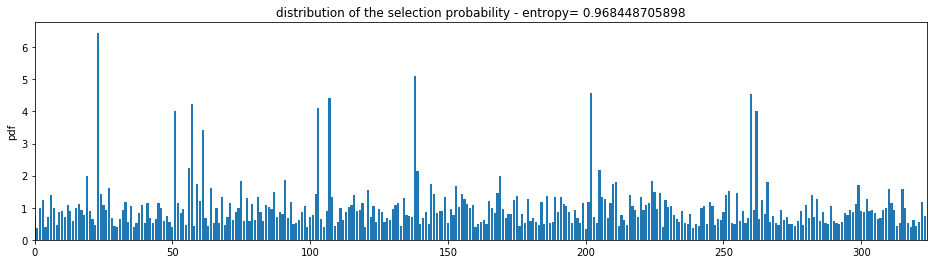

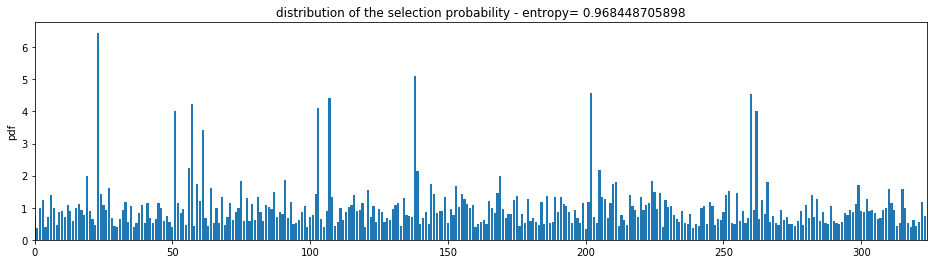

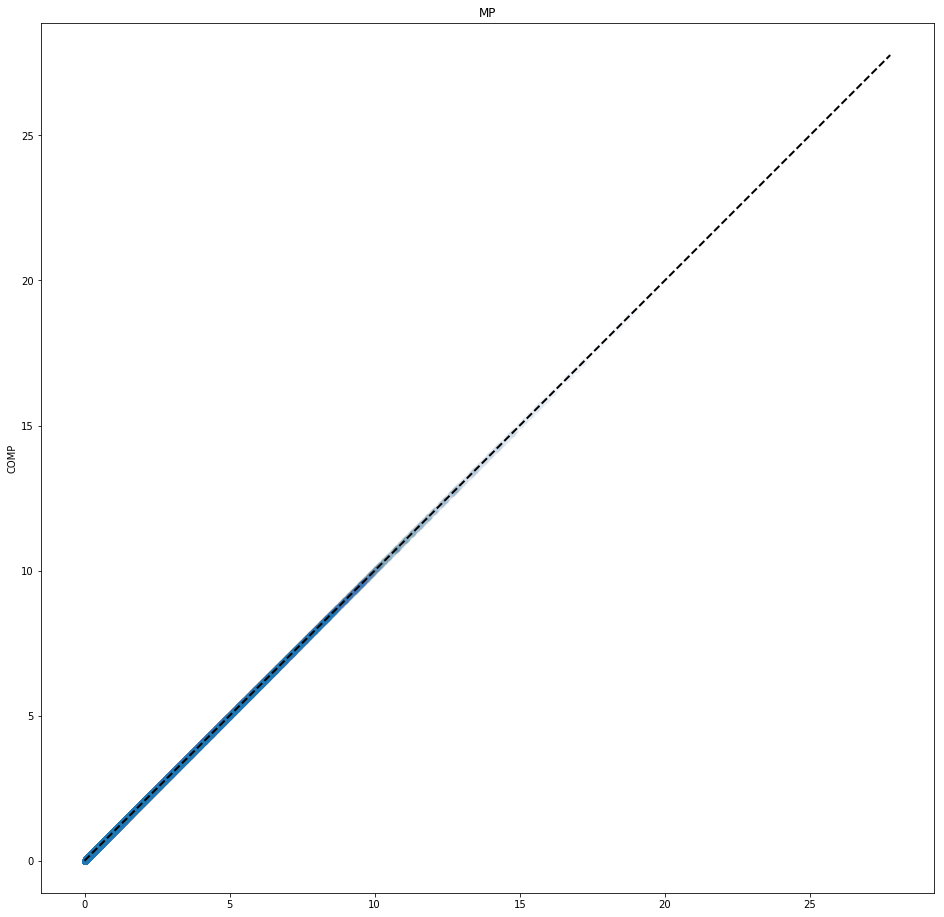

In [56]:
fig, ax = plot_proba_histogram(sparse_code_mp)
fig.show()
fig, ax = plot_proba_histogram(sparse_code_comp)

fig, ax = plot_scatter_MpVsComp(sparse_code_mp, sparse_code_comp)

## gradient descent 

Shape of modulation function (324, 512)
Learning step 0


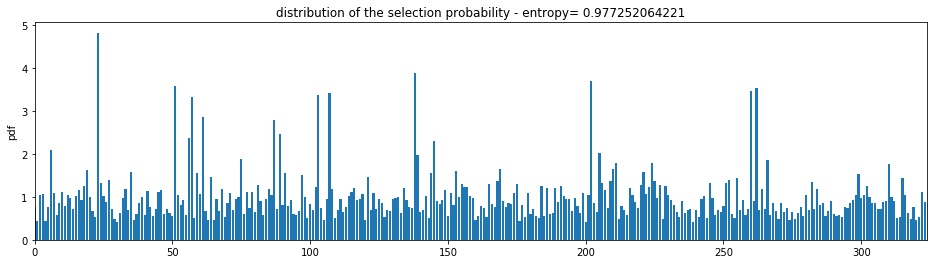

Learning step 100


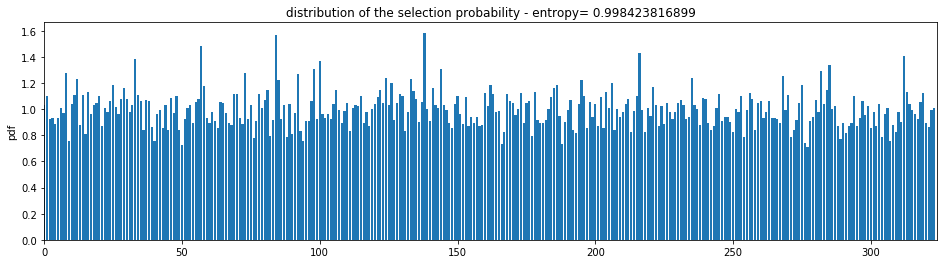

Learning step 200


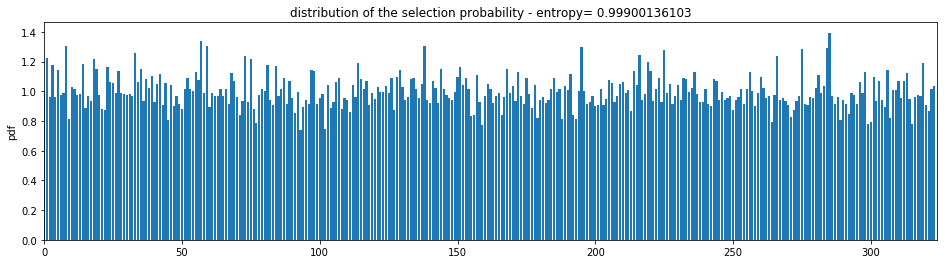

Learning step 300


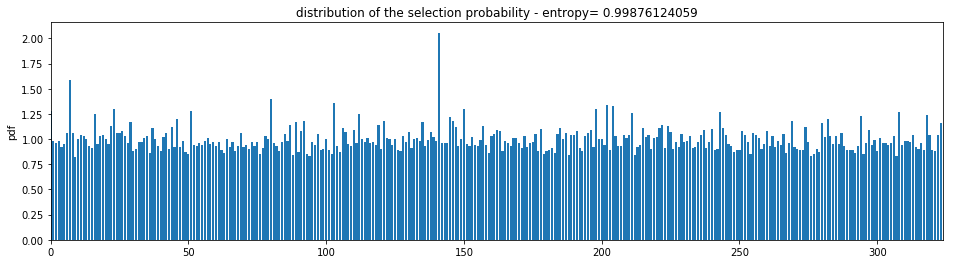

Learning step 400


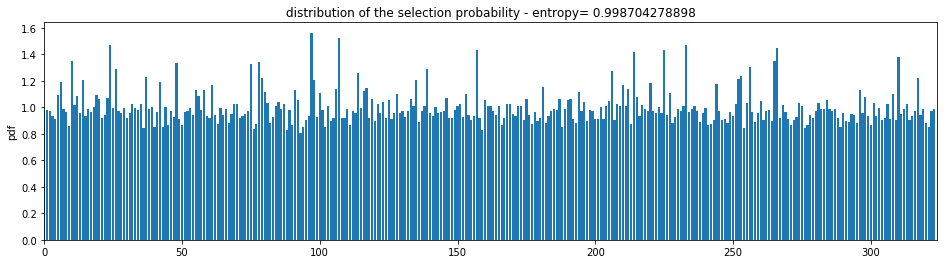

Learning step 500


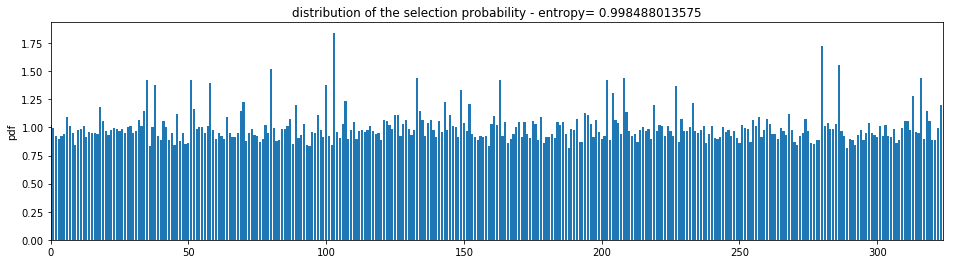

Learning step 600


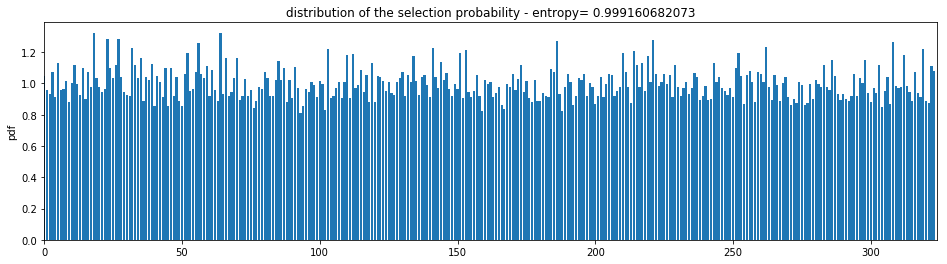

Learning step 700


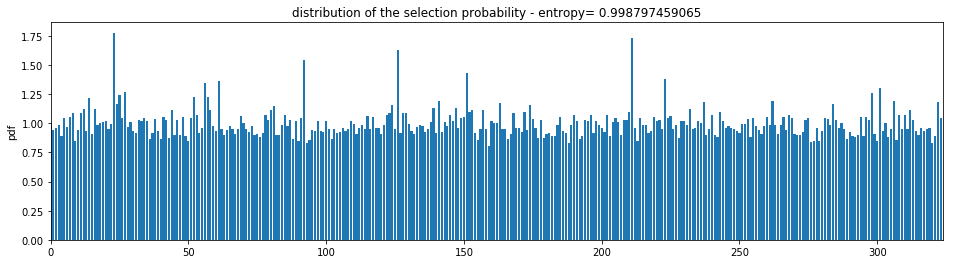

Learning step 800


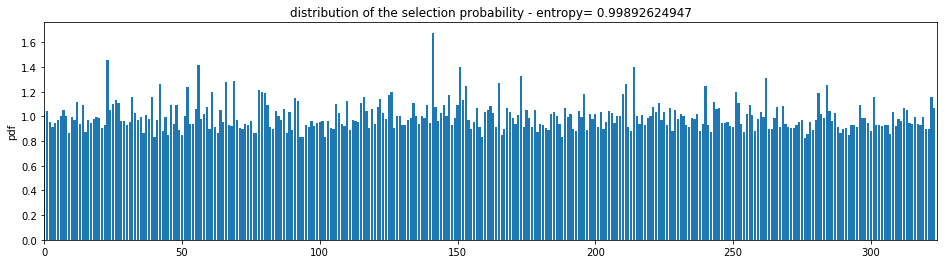

Learning step 900


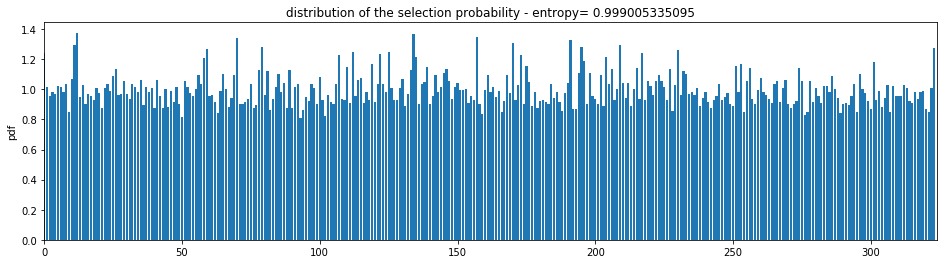

In [57]:
P_cum = np.linspace(0, 1, nb_quant, endpoint=True)[np.newaxis, :] * np.ones((nb_filter, 1))
print('Shape of modulation function', P_cum.shape)

eta_homeo = .01

for i in range(1000//DEBUG_DOWNSCALE):
    sparse_code = comp(data_test, dico_partial_learning.dictionary, P_cum, C=C, do_sym=do_sym, verbose=0)
    P_cum_ = get_P_cum(sparse_code, C=C, nb_quant=nb_quant)
    P_cum = (1-eta_homeo) * P_cum + eta_homeo  * P_cum_
    if i % (100//DEBUG_DOWNSCALE) == 0:
        print('Learning step', i)
        fig, ax = plot_proba_histogram(sparse_code)
        plt.show()

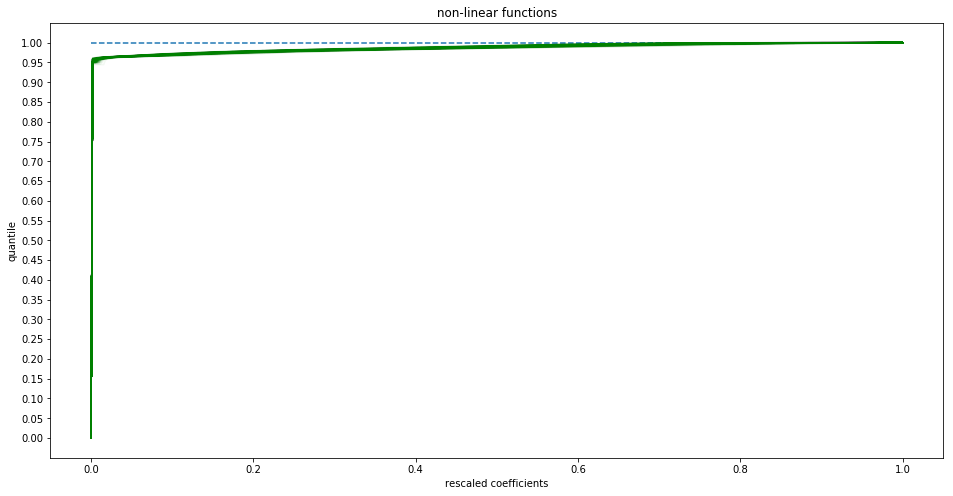

In [58]:
from shl_scripts.shl_tools import plot_P_cum
fig, ax = plot_P_cum(P_cum, verbose=False);

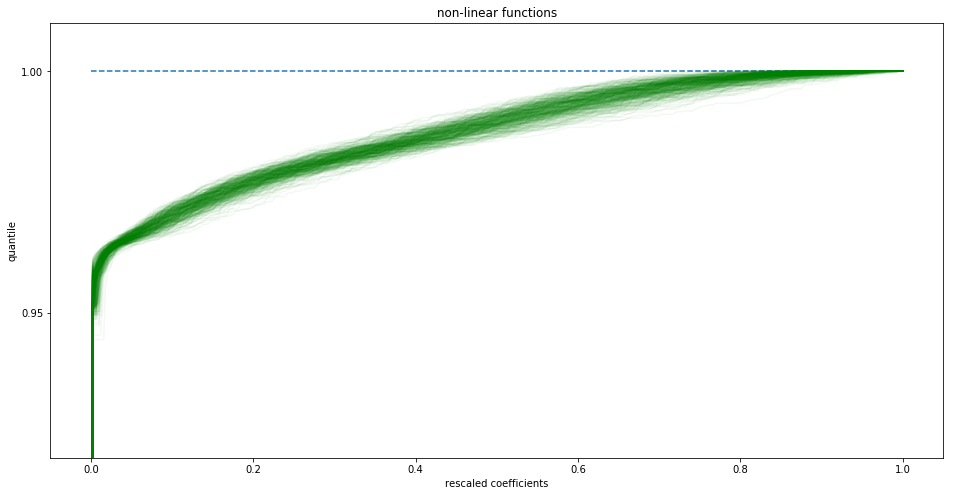

In [59]:
fig, ax = plot_P_cum(P_cum, verbose=False)
ax.set_ylim(0.92, 1.01);

Compared to the [previous post](https://laurentperrinet.github.io/sciblog/posts/2017-03-29-testing-comps.html), one observes that the distribution gets progressively more uniform which was our goal. This implementation makes the Matching Pursuit algorithm running faster such that we can integrate it to the [SHL package](https://github.com/bicv/SHL_scripts). This will be done in the [next post](https://laurentperrinet.github.io/sciblog/posts/2017-03-29-testing-comps-fastpcum_scripted.html).